Importing all the Needed Libraries 

In [8]:
import os

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

class AnimalFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.images = []
        self.labels = []

        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for img in os.listdir(cls_path):
                self.images.append(os.path.join(cls_path, img))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [10]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [11]:
train_dataset = AnimalFaceDataset(
    root_dir="train",
    transform=train_transforms
)

val_dataset = AnimalFaceDataset(
    root_dir="val",
    transform=val_transforms
)


Loading the Data Set in Batches 

In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)


In [14]:
images, labels = next(iter(train_loader))
print(images.shape)   # Expected: [32, 3, 224, 224]
print(labels.shape)   # Expected: [32]


torch.Size([32, 3, 224, 224])
torch.Size([32])


BUILDING A CNN

In [15]:
class AnimalCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        
        self.pool = nn.MaxPool2d(2, 2)

    
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) 
        x = self.pool(torch.relu(self.conv2(x)))  
        x = self.pool(torch.relu(self.conv3(x)))  
        x = self.pool(torch.relu(self.conv4(x)))  

        x = x.view(x.size(0), -1)                  
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [19]:
model = AnimalCNN(num_classes=3)
model = model.to(device)

MODEL SUMARY 

In [22]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 256, 28, 28]         295,168
         MaxPool2d-8          [-1, 256, 14, 14]               0
            Linear-9                  [-1, 512]      25,690,624
          Dropout-10                  [-1, 512]               0
           Linear-11                    [-1, 3]           1,539
Total params: 26,080,579
Trainable params: 26,080,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

Training the Model

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 18

best_val_acc = 0.0  

num_epochs = 18

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total

    if val_acc > best_val_acc:
        best_val_acc = val_acc

        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_accuracy": best_val_acc
        }, "best_model.pth")

        print(f"✅ Best model saved at epoch {epoch+1} with Val Acc: {best_val_acc:.2f}%")

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Loss: {train_loss:.4f} "
        f"Val Acc: {val_acc:.2f}%"
    )


✅ Best model saved at epoch 1 with Val Acc: 94.33%
Epoch [1/18] Loss: 0.3965 Val Acc: 94.33%
✅ Best model saved at epoch 2 with Val Acc: 96.40%
Epoch [2/18] Loss: 0.1314 Val Acc: 96.40%
✅ Best model saved at epoch 3 with Val Acc: 97.87%
Epoch [3/18] Loss: 0.0932 Val Acc: 97.87%
Epoch [4/18] Loss: 0.0785 Val Acc: 97.87%
Epoch [5/18] Loss: 0.0615 Val Acc: 97.20%
✅ Best model saved at epoch 6 with Val Acc: 98.47%
Epoch [6/18] Loss: 0.0525 Val Acc: 98.47%
Epoch [7/18] Loss: 0.0496 Val Acc: 97.67%
Epoch [8/18] Loss: 0.0457 Val Acc: 97.53%
✅ Best model saved at epoch 9 with Val Acc: 98.60%
Epoch [9/18] Loss: 0.0384 Val Acc: 98.60%
Epoch [10/18] Loss: 0.0421 Val Acc: 97.60%
Epoch [11/18] Loss: 0.0344 Val Acc: 97.93%
Epoch [12/18] Loss: 0.0350 Val Acc: 98.53%
Epoch [13/18] Loss: 0.0313 Val Acc: 98.20%
Epoch [14/18] Loss: 0.0303 Val Acc: 97.53%
✅ Best model saved at epoch 15 with Val Acc: 99.00%
Epoch [15/18] Loss: 0.0314 Val Acc: 99.00%
Epoch [16/18] Loss: 0.0320 Val Acc: 98.67%
Epoch [17/18] 

In [27]:
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Evaluating model from epoch:", checkpoint["epoch"])
print("Best validation accuracy:", checkpoint["val_accuracy"])


Evaluating model from epoch: 15
Best validation accuracy: 99.0


In [28]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [29]:
accuracy = (all_preds == all_labels).mean() * 100
print(f"Final Validation Accuracy: {accuracy:.2f}%")


Final Validation Accuracy: 99.00%


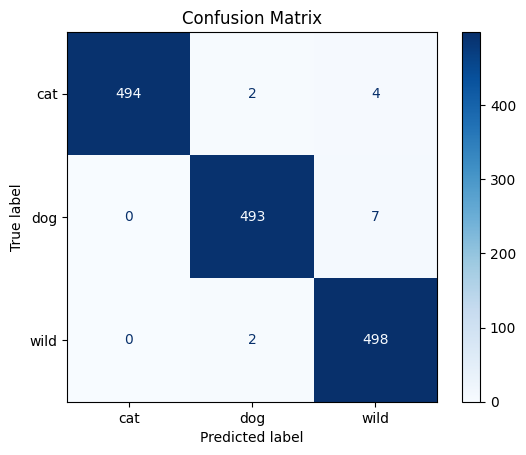

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=train_dataset.classes
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [31]:
from sklearn.metrics import classification_report

report = classification_report(
    all_labels,
    all_preds,
    target_names=train_dataset.classes
)

print(report)


              precision    recall  f1-score   support

         cat       1.00      0.99      0.99       500
         dog       0.99      0.99      0.99       500
        wild       0.98      1.00      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



LOAD THE MODEL


In [32]:
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


AnimalCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

In [33]:
class_names = train_dataset.classes
print(class_names)  # ['cat', 'dog', 'wild']


['cat', 'dog', 'wild']


In [34]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict_image(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")

    # Apply validation transforms
    input_tensor = val_transforms(image)

    # Add batch dimension → (1, 3, 224, 224)
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)   # convert logits → probabilities

        confidence, pred_index = torch.max(probs, dim=1)

    predicted_class = class_names[pred_index.item()]
    confidence = confidence.item() * 100

    # ---- Display ----
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"{predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis("off")
    plt.show()

    print("🦠 Predicted Class:", predicted_class)
    print(f"Confidence: {confidence:.2f}%")

    return predicted_class, confidence


TEST USING IMAGE FROM INTERNET 

test_images/dog1.jpg


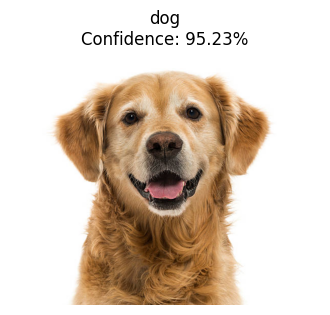

🦠 Predicted Class: dog
Confidence: 95.23%
test_images/dog2.jpg


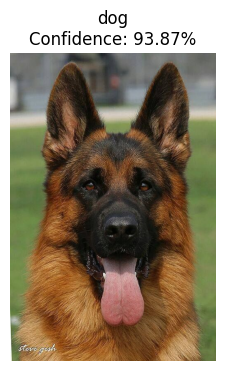

🦠 Predicted Class: dog
Confidence: 93.87%
test_images/cat1.jpg


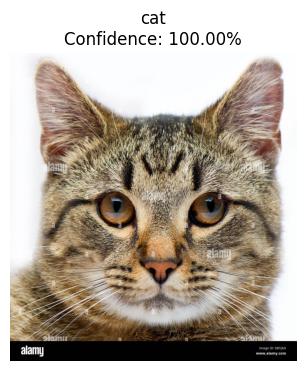

🦠 Predicted Class: cat
Confidence: 100.00%
test_images/wild1.jpg


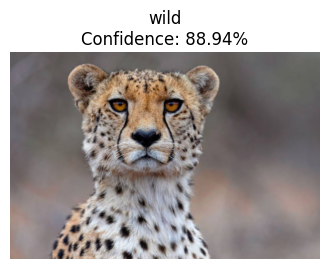

🦠 Predicted Class: wild
Confidence: 88.94%


In [39]:
test_images = [
    "test_images/dog1.jpg",
    "test_images/dog2.jpg",
    "test_images/cat1.jpg",
    "test_images/wild1.jpg"
]

for img_path in test_images:
    print(img_path)
    predict_image(img_path)
